In [1]:
## 读取数据
import pandas as pd
df=pd.read_csv('/kaggle/input/waimai-10k/waimai_10k.csv')
df.head()


,label,review
0,1,很快，好吃，味道足，量大
1,1,没有送水没有送水没有送水
2,1,非常快，态度好。
3,1,方便，快捷，味道可口，快递给力
4,1,菜味道很棒！送餐很及时！


In [2]:
labels=list(df['label'].values)
txt_list=list(df['review'].values)
labels[:10],txt_list[:10]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 ['很快，好吃，味道足，量大',
  '没有送水没有送水没有送水',
  '非常快，态度好。',
  '方便，快捷，味道可口，快递给力',
  '菜味道很棒！送餐很及时！',
  '今天师傅是不是手抖了，微辣格外辣！',
  '送餐快,态度也特别好,辛苦啦谢谢',
  '超级快就送到了，这么冷的天气骑士们辛苦了。谢谢你们。麻辣香锅依然很好吃。',
  '经过上次晚了2小时，这次超级快，20分钟就送到了……',
  '最后五分钟订的，卖家特别好接单了，谢谢。'])

In [6]:
#创建字符表
char_set=set()
for txt in txt_list:
    for char in txt:
        char_set.add(char)
char_list=list(char_set)
n_chars=len(char_list)+1
print('词表大小：',n_chars)
char_list[:5]

词表大小： 2559


['i', '歉', '屮', '༵', '鴨']

In [7]:
import torch
def text_to_tensor(text):#
    tensor=torch.zeros(len(text),dtype=torch.long)
    for i,char in enumerate(text):
        try:
            ind=char_list.index(char)
        except:
            ind=n_chars-1
        tensor[i]=ind
    return tensor

def tensor_to_text(input_tensor):
    s=""
    input_tensor=input_tensor.squeeze(0)
    for i in range(input_tensor.shape[0]):
        s+=char_list[input_tensor[i].item()]
    return s
embed=torch.nn.Embedding(n_chars,100)
test=txt_list[1]
print(test)
print(text_to_tensor(test))
print(embed(text_to_tensor(test)).shape)
print(tensor_to_text(text_to_tensor(test)))

没有送水没有送水没有送水
tensor([1527, 1331, 1245, 1323, 1527, 1331, 1245, 1323, 1527, 1331, 1245, 1323])
torch.Size([12, 100])
没有送水没有送水没有送水


In [9]:
## 将数据都处理成tensor
all_data=[]
classes=['bad','good']

for txt,label in zip(list(txt_list),list(labels)):
    txt=text_to_tensor(txt)
    label=torch.tensor(label,dtype=torch.long)
    all_data.append((txt,label))
all_data[:5]

[(tensor([2020, 1474, 1832, 2069, 2504, 1832, 2497, 2056,  930, 1832, 2380, 2475]),
  tensor(1)),
 (tensor([1527, 1331, 1245, 1323, 1527, 1331, 1245, 1323, 1527, 1331, 1245, 1323]),
  tensor(1)),
 (tensor([1220, 1431, 1474, 1832,  856,  132, 2069, 2161]), tensor(1)),
 (tensor([ 896,  536, 1832, 1474, 1954, 1832, 2497, 2056,  929, 1861, 1832, 1474,
          1385, 2354, 2147]),
  tensor(1)),
 (tensor([1696, 2497, 2056, 2020, 1357,  516, 1245, 1130, 2020, 1970,  108,  516]),
  tensor(1))]

In [10]:
## 打乱、划分数据集
import random
random.shuffle(all_data)
data_len=len(all_data)

split_ratio=0.7
train_len=int(data_len*split_ratio)
train_data=all_data[:train_len]
test_data=all_data[train_len:]

print(len(test_data))

3597


In [12]:
## 手写单隐藏层RNN
from torch import nn
class RNN(nn.Module):
    def __init__(self,word_count,embedding_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size=hidden_size
        self.embedding=nn.Embedding(word_count,embedding_size)
        self.i2h=nn.Linear(embedding_size+hidden_size,hidden_size)#RNN权重共享
        self.i2o=nn.Linear(embedding_size+hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
    def forward(self,x,hidden):
        word_vector=self.embedding(x)
        combined=torch.cat([word_vector,hidden],dim=1)
        hidden=self.i2h(combined)
        output=self.i2o(combined)
        output=self.softmax(output)
        return output,hidden
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)
    

        

In [104]:
## 测试RNN
embedding_size=200
n_hidden=128
n_class=2
rnn=RNN(n_chars,embedding_size,n_hidden,n_class)

input_tensor=all_data[1][0]
hidden=rnn.init_hidden()
output,hidden=rnn(input_tensor[0].unsqueeze(dim=0),hidden)
print(output,hidden)

tensor([[-0.4472, -1.0201]], grad_fn=<LogSoftmaxBackward0>) tensor([[-0.0966, -0.4665, -0.1183, -0.2810, -0.0077, -0.0342, -0.2119, -0.2632,
         -0.2926, -0.3624, -0.3419, -0.2175, -0.3822, -0.3430, -0.4258,  0.6271,
          0.3097, -0.4572, -0.1795, -0.1811, -0.2192,  0.4578, -0.1724, -0.0348,
         -0.0996,  0.5215,  0.3241,  0.3290, -0.0712, -0.3839, -0.7732, -0.0767,
         -0.3132, -0.1043,  0.0381, -0.3052, -0.2384,  0.1297,  0.0683,  0.2184,
         -0.3277, -0.6654, -0.4540, -0.2388,  0.9076, -0.3745, -0.0408,  0.1036,
          0.2587,  0.3505,  0.4563,  0.5832,  0.7226,  0.1858, -0.1493,  0.0657,
         -0.0054,  0.5907,  0.4838,  0.1476, -0.7828, -0.4390, -0.4592, -0.3781,
         -0.0086,  0.0231,  0.3816, -0.1291, -0.4141, -0.2241, -0.0567, -0.2987,
          0.0938, -0.3319,  0.5381, -0.6686, -0.0415, -0.5490,  0.4115, -0.5267,
         -0.3482, -1.0784,  0.1560, -0.0458, -0.4346, -0.4767, -0.0555, -0.1364,
         -0.2629, -0.4657, -0.8517, -0.2134,  0.4

In [64]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 得到rnn最后一层output
def run_rnn(rnn,input_tensor,device=device):
    hidden=rnn.init_hidden().to(device)
    for i in range(input_tensor.size()[0]):
        output,hidden=rnn(input_tensor[i].unsqueeze(dim=0),hidden)
    return output
run_rnn(rnn,input_tensor,device=input_tensor.device)

In [113]:
## 梯度裁剪
## 控制参数的L2范数不大于theta
## 训练速度会变慢
def grad_clipping(net,theta):
    params=[p for p in net.parameters() if p.requires_grad]
    norm=torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))#所有参数梯度组成的向量的L2范数
    if norm>theta:
        for param in params:
            param.grad[:]*=theta/norm

In [148]:
## 训练和评估
def train(rnn,criterion,input_tensor,label_tensor,device=device):
    rnn.zero_grad()
    output=run_rnn(rnn,input_tensor)
    loss=criterion(output,label_tensor)
    
    loss.backward()
    grad_clipping(rnn, 1)
    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-lr)
    return output,loss.item()

def evaluate(rnn,input_tensor,device=device):
    with torch.no_grad():
        hidden=rnn.init_hidden().to(device)
        output=run_rnn(rnn,input_tensor)
        return output


In [159]:
from tqdm import tqdm
import matplotlib.pyplot as plt
def train_k_epochs(net,epochs,lr,criterion,device,plot_loss=True):
    loss_sum=0
    all_losses=[]
    plot_every=100

    for epoch in range(epochs):
        random.shuffle(train_data)
        for i,(input_tensor,label_tensor) in enumerate(tqdm(train_data)):
            if i>5000:
                break
            input_tensor=input_tensor.to(device)
            label_tensor=label_tensor.to(device)
            output,loss=train(net,criterion,input_tensor,label_tensor.unsqueeze(0))
            loss_sum+=loss
            if i %plot_every==0:
                all_losses.append(loss_sum/plot_every)
                loss_sum=0
        c=0
        random.shuffle(test_data)
        for i,(text,label) in enumerate(tqdm(test_data)):
            if i>500:
                break
            text=text.to(device)
            output=evaluate(net,text)
            predict=torch.argmax(output)
            if predict==label.item():
                c+=1
        print('acc:',c/500)
        print(evaluate(rnn,input_tensor.cuda()))#检查是否有梯度爆炸
    if plot_loss:
        ## 损失变化图像
        plt.figure(figsize=(6,6))
        plt.ylabel('Average Loss')
        plt.plot(all_losses[1:])
        plt.show()




 14%|█▍        | 501/3597 [00:01<00:10, 291.02it/s]


acc: 0.642
tensor([[-0.0167, -4.1025]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 279.17it/s]


acc: 0.664
tensor([[-0.4379, -1.0368]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 273.26it/s]


acc: 0.688
tensor([[-1.1259, -0.3921]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 270.59it/s]


acc: 0.72
tensor([[-1.6184, -0.2209]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:10, 293.12it/s]


acc: 0.738
tensor([[-0.5667, -0.8379]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 280.32it/s]


acc: 0.686
tensor([[-0.0316, -3.4711]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 274.91it/s]


acc: 0.744
tensor([[-4.7684e-04, -7.6486e+00]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:10, 285.58it/s]


acc: 0.746
tensor([[-0.0071, -4.9534]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:12, 253.06it/s]


acc: 0.792
tensor([[-0.1018, -2.3348]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 277.06it/s]


acc: 0.83
tensor([[-5.6942e-04, -7.4712e+00]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:10, 301.39it/s]


acc: 0.85
tensor([[-1.0847e-04, -9.1288e+00]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:10, 300.99it/s]


acc: 0.812
tensor([[-3.9629e-04, -7.8337e+00]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:10, 297.76it/s]


acc: 0.848
tensor([[-1.5353e-04, -8.7820e+00]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 266.26it/s]


acc: 0.854
tensor([[-1.3208e-04, -8.9323e+00]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:10, 290.46it/s]


acc: 0.848
tensor([[-0.1477, -1.9852]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:10, 289.92it/s]


acc: 0.838
tensor([[-0.0109, -4.5266]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 279.52it/s]


acc: 0.862
tensor([[-0.0100, -4.6096]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:10, 282.54it/s]


acc: 0.83
tensor([[-1.8866e-03, -6.2739e+00]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 274.47it/s]


acc: 0.856
tensor([[-8.2852e+00, -2.5222e-04]], device='cuda:0')


 14%|█▍        | 501/3597 [00:01<00:11, 265.34it/s]


acc: 0.86
tensor([[-1.7432e-03, -6.3529e+00]], device='cuda:0')


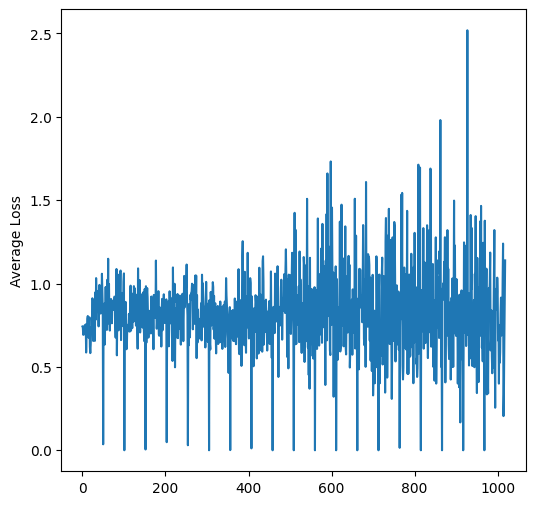

In [160]:
## 训练
## 训练次数过多会梯度爆炸

mode='build'#load:加载已经训过的模型;build:重新训练
epochs =20
lr=0.001
embedding_size=200
n_hidden=128
n_class=2
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
rnn=RNN(n_chars,embedding_size,n_hidden,n_class).to(device)
criterion=nn.NLLLoss()## result,target,


if mode=='load':
    rnn.load_state_dict(torch.load('rnn_parameter.pkl'))

train_k_epochs(rnn,epochs,lr,criterion,device)

In [161]:
## 在完整测试集上计算测试结果
bad_list=[]
good_list=[]
c=0
for i,(text,label) in enumerate(tqdm(test_data)):
    text=text.to(device)
    output=evaluate(rnn,text)
    predict=torch.argmax(output)
    #print(output)
    if predict==label.item():
        c+=1
    if predict==0:
        bad_list.append(tensor_to_text(text))
    else :
        good_list.append(tensor_to_text(text))
print('acc:',c/len(test_data))

## 查看分类为好和分类为坏的样例
for x in random.sample(bad_list,5):
    print('bad: '+x)
for x in random.sample(good_list,5):
    print('good: '+x)

100%|██████████| 3597/3597 [00:14<00:00, 249.90it/s]

acc: 0.849596886294134
bad: 卷饼和香肠那么粗，严重忽悠人啊！~
bad: 为什么肉皮上的毛毛没有弄掉？是不是只要挣钱管他死活？虽然吃不死人，但是看着很恶心的。
bad: 大哥,吸管没有，番茄酱没有
bad: 卷饼的菜和图片上差别太大了…半点黄瓜丝也没有，青椒丝就一根，剩下基本是土豆。淡而无味。再也不买了。
bad: 超时半个小时，还送错东西，并且还少了两杯豆浆，最后打了十几次客服电话竟然一直没人接,呵呵
good: 牛肉非常非常老，腥味太重
good: 在店里吃过多次，第一次在百度配送订购，食物非常好吃，配送小哥也很辛苦！谢谢！
good: 今天真是超级快，感觉刚下单就送到啦哈哈哈
good: 真不错，价格便宜实惠，分量足，最满意的一家
good: 好吃,满意


In [162]:
#仅保存模型参数
torch.save(rnn.state_dict(),'rnn_parameter.pkl')

embedding_size=200
n_hidden=128
n_class=2
rnn1=RNN(n_chars,embedding_size,n_hidden,n_class)
rnn1.load_state_dict(torch.load('rnn_parameter.pkl'))

<All keys matched successfully>

In [83]:
#保存模型
torch.save(rnn,'rnn_model.pkl')
rnn1=torch.load('rnn_model.pkl')

In [163]:
## 保存词表
import json
with open('char_list.json','w') as f:
    json.dump(char_list,f)

## 加载词表
with open('char_list.json','r') as f:
    char_list1=json.load(f)

In [164]:
## 测试
def get_class(txt):
    txt_tensor=text_to_tensor(txt)
    output=evaluate(rnn,txt_tensor.cuda())
    topi=torch.argmax(output)
    print(classes[topi.item()]+': '+txt)

get_class('好吃，量也大，值得推荐')
get_class('垃圾')
get_class('不好吃')
get_class('再也不来这家店了!')
get_class('量很足！')
get_class('优秀！')
get_class('一分钱一分货')

good: 好吃，量也大，值得推荐
bad: 垃圾
bad: 不好吃
bad: 再也不来这家店了!
good: 量很足！
good: 优秀！
bad: 一分钱一分货


## GRU

In [32]:
from torch import nn
class GRU(nn.Module):
    def __init__(self,word_count,embedding_size,hidden_size,output_size):
        super().__init__()
        self.embedding=nn.Embedding(word_count,embedding_size)
        self.hidden_size=hidden_size
        input_size=embedding_size+hidden_size
        self.i2r=nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Sigmoid(),
        )
        self.i2z=nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Sigmoid(),
        )
        self.r2h_=nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Tanh(),
        )
        self.h2o=nn.Sequential(
            nn.Linear(hidden_size,output_size),
        )
        self.softmax=nn.LogSoftmax(dim=1)
    def forward(self,x,hidden):
        word_vector=self.embedding(x)
        input_cat=torch.cat([word_vector,hidden],dim=-1)
        R_t=self.i2r(input_cat)
        Z_t=self.i2z(input_cat)
        H_=self.r2h_(torch.cat([word_vector,torch.mul(R_t,hidden)],dim=-1))#h'=tanh(W(torch.cat(x,R_t*H_t-1))+b)
        H=torch.mul(Z_t,hidden)+torch.mul((1-Z_t),H_)
        output=self.h2o(H)
        output=self.softmax(output)
        return output,H
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [33]:
## 测试GRU
embedding_size=200
n_hidden=128
n_class=2
gru=GRU(n_chars,embedding_size,n_hidden,n_class)

input_tensor=all_data[1][0]
hidden=gru.init_hidden()
output,hidden=gru(input_tensor[0].unsqueeze(dim=0),hidden)
print(output,hidden)

tensor([[-0.6555, -0.7322]], grad_fn=<LogSoftmaxBackward0>) tensor([[-0.0942, -0.3729, -0.2097, -0.0390, -0.1578,  0.2443, -0.1208,  0.1036,
          0.2936, -0.0544, -0.3768,  0.1045, -0.4564, -0.0620, -0.0978, -0.0562,
          0.1265, -0.2919, -0.0911, -0.3167, -0.1746, -0.0448, -0.1231, -0.0510,
         -0.0884, -0.0944, -0.1609,  0.2455,  0.0297, -0.0244, -0.0102,  0.0507,
         -0.2226, -0.0817, -0.0571, -0.1469, -0.1385,  0.2092,  0.2167, -0.0535,
          0.3046,  0.0857, -0.0776, -0.1493, -0.0837, -0.0392, -0.0216, -0.0015,
          0.4283,  0.2079, -0.3007,  0.0878, -0.0918,  0.1683,  0.3100, -0.2721,
         -0.3050,  0.1882,  0.0492,  0.2025,  0.2112,  0.1027,  0.1153,  0.0305,
          0.1810,  0.3453, -0.2420,  0.3965,  0.2068, -0.0064,  0.1945,  0.1166,
          0.0946, -0.0534,  0.0206, -0.0407, -0.2339,  0.0859,  0.4324, -0.2978,
          0.5411, -0.0613, -0.1376,  0.1666, -0.1046,  0.1065,  0.1853,  0.0083,
         -0.1626, -0.0980, -0.1681, -0.0366, -0.1

In [34]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def run_gru(gru,input_tensor,device=device):
    hidden=gru.init_hidden().to(device)
    for i in range(input_tensor.size()[0]):
        output,hidden=gru(input_tensor[i].unsqueeze(dim=0),hidden)
    return output
run_gru(gru,input_tensor,device=input_tensor.device)

tensor([[-0.6759, -0.7107]], grad_fn=<LogSoftmaxBackward0>)

In [69]:
## 训练和评估
def train(gru,criterion,input_tensor,label_tensor,device=device):
    gru.zero_grad()
    output=run_gru(gru,input_tensor)
    loss=criterion(output,label_tensor)
    
    loss.backward()
    for p in gru.parameters():
        p.data.add_(p.grad.data,alpha=-lr)
    return output,loss.item()

def evaluate(gru,input_tensor,device=device):
    with torch.no_grad():
        output=run_gru(gru,input_tensor)
        return output


In [35]:
from tqdm import tqdm
import matplotlib.pyplot as plt
def train_k_epochs(net,epochs,lr,criterion,device,plot_loss=True):
    loss_sum=0
    all_losses=[]
    plot_every=100

    for epoch in range(epochs):
        random.shuffle(train_data)
        for i,(input_tensor,label_tensor) in enumerate(tqdm(train_data)):
            if i>5000:
                break
            input_tensor=input_tensor.to(device)
            label_tensor=label_tensor.to(device)
            output,loss=train(net,criterion,input_tensor,label_tensor.unsqueeze(0))
            loss_sum+=loss
            if i %plot_every==0:
                all_losses.append(loss_sum/plot_every)
                loss_sum=0
        c=0
        random.shuffle(test_data)
        for i,(text,label) in enumerate(tqdm(test_data)):
            if i>500:
                break
            text=text.to(device)
            output=evaluate(net,text)
            predict=torch.argmax(output)
            if predict==label.item():
                c+=1
        print('acc:',c/500)
        print(evaluate(gru,input_tensor.cuda()))#检查是否有梯度爆炸
    if plot_loss:
        ## 损失变化图像
        plt.figure(figsize=(6,6))
        plt.ylabel('Average Loss')
        plt.plot(all_losses[1:])
        plt.show()




 14%|█▍        | 501/3597 [00:04<00:28, 110.19it/s]


acc: 0.734
tensor([[-0.7316, -0.6561]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:28, 109.43it/s]


acc: 0.756
tensor([[-0.4780, -0.9677]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:28, 108.16it/s]


acc: 0.79
tensor([[-0.5559, -0.8523]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:28, 108.15it/s]


acc: 0.812
tensor([[-2.7303, -0.0674]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:29, 106.54it/s]


acc: 0.82
tensor([[-0.0698, -2.6961]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:30, 100.73it/s]


acc: 0.854
tensor([[-0.1269, -2.1273]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:29, 104.32it/s]


acc: 0.866
tensor([[-0.3653, -1.1842]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:30, 102.93it/s]


acc: 0.85
tensor([[-0.0611, -2.8263]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:26, 115.50it/s]


acc: 0.848
tensor([[-3.7332, -0.0242]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:28, 109.96it/s]


acc: 0.874
tensor([[-0.0963, -2.3882]], device='cuda:0')


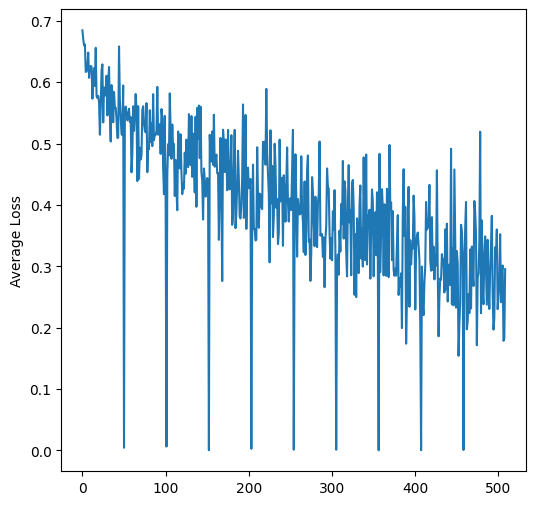

In [36]:
## 训练
## 训练次数过多会梯度爆炸

mode='build'#load:加载已经训过的模型;build:重新训练
epochs =10
lr=0.001
embedding_size=200
n_hidden=128
n_class=2
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gru=GRU(n_chars,embedding_size,n_hidden,n_class).to(device)
criterion=nn.NLLLoss()## result,target,


if mode=='load':
    gru.load_state_dict(torch.load('gru_parameter.pkl'))

train_k_epochs(gru,epochs,lr,criterion,device)
torch.save(gru.state_dict(),'gru_parameter.pkl')

In [70]:
## 在完整测试集上计算测试结果
bad_list=[]
good_list=[]
c=0
for i,(text,label) in enumerate(tqdm(test_data)):
    text=text.to(device)
    output=evaluate(gru,text)
    predict=torch.argmax(output)
    #print(output)
    if predict==label.item():
        c+=1
    if predict==0:
        bad_list.append(tensor_to_text(text))
    else :
        good_list.append(tensor_to_text(text))
print('acc:',c/len(test_data))

## 查看分类为好和分类为坏的样例
for x in random.sample(bad_list,5):
    print('bad: '+x)
for x in random.sample(good_list,5):
    print('good: '+x)

100%|██████████| 3597/3597 [00:35<00:00, 102.05it/s]

acc: 0.873783708646094
bad: 好咸的酱香鸡腿啊！
bad: 送的太慢了！！！！
bad: 外送的质量太差了～全是粉丝～
bad: 有点慢，番茄酱没给我带
bad: 送外卖的大妈一定是上错楼层了，还横的无与伦比，各种吼！太差了
good: 价格实惠，味道不错。
good: 配送人员服务态度好，菜品太美味了，还会再来，满意！
good: 送餐非常速度，负责人，热情！
good: 骑士太棒了，服务态度极好，地址好像写错了，非常抱歉，辛苦啦
good: 送餐非常快,态度特别好,谢谢


## LSTM

In [50]:
class LSTM(nn.Module):
    def __init__(self,word_count,embedding_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size=hidden_size
        self.embedding=nn.Embedding(word_count,embedding_size)
        input_size=embedding_size+hidden_size
        self.x2F=nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Sigmoid(),
        )
        self.x2I=nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Sigmoid(),
        )
        self.x2O=nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Sigmoid(),
        )
        self.x2C_=nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.Tanh(),
        )
        self.output=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
        self.tanh=nn.Tanh()
    def forward(self,input_tensor,hidden,C_last):
        word_vector=self.embedding(input_tensor)
        input_cat=torch.cat([word_vector,hidden],dim=-1)
        F_t=self.x2F(input_cat)
        I_t=self.x2I(input_cat)
        O_t=self.x2O(input_cat)
        C_=self.x2C_(input_cat)
        C=torch.mul(F_t,C_last)+torch.mul(I_t,C_)
        H=torch.mul(O_t,self.tanh(C))
        output=self.output(H)
        output=self.softmax(output)
        return output,H,C
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size),torch.zeros(1,self.hidden_size)
        

In [71]:
## 测试RNN
embedding_size=200
n_hidden=128
n_class=2
lstm=LSTM(n_chars,embedding_size,n_hidden,n_class)

input_tensor=all_data[1][0]
hidden,C_last=lstm.init_hidden()
output,hidden,C_last=lstm(input_tensor[0].unsqueeze(dim=0),hidden,C_last)
print(output,hidden)

tensor([[-0.6525, -0.7355]], grad_fn=<LogSoftmaxBackward0>) tensor([[ 0.0105, -0.0770,  0.0591,  0.0351,  0.0585,  0.1678,  0.0826,  0.0100,
          0.1276, -0.2119,  0.0467,  0.0133,  0.0609,  0.0543,  0.0693, -0.1291,
          0.1112,  0.1109, -0.0329, -0.0520,  0.2196, -0.0676, -0.0048, -0.0465,
         -0.0277,  0.1396,  0.2333,  0.2200,  0.1213, -0.1429, -0.1641, -0.0193,
         -0.0128, -0.1134, -0.0883,  0.0238, -0.1438,  0.0613, -0.2005,  0.0818,
         -0.0488,  0.0745,  0.0842, -0.1434,  0.0072, -0.1991,  0.1274, -0.0030,
         -0.0484,  0.2301, -0.0778, -0.1884, -0.0156, -0.0512, -0.0698,  0.0672,
         -0.1030, -0.0205, -0.1126, -0.0793,  0.0271,  0.0184, -0.0674,  0.0724,
          0.0102, -0.0610, -0.0110, -0.0273,  0.0087,  0.0637, -0.1193,  0.1095,
          0.1512,  0.0245,  0.0468,  0.0047, -0.2678,  0.1220, -0.2015,  0.1097,
          0.0864, -0.1464, -0.0523,  0.0221,  0.0422,  0.1628, -0.1009, -0.0281,
         -0.0239, -0.0269, -0.2242, -0.1164, -0.1

In [72]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def run_lstm(lstm,input_tensor,device=device):
    hidden,C_last=lstm.init_hidden()
    hidden=hidden.to(device)
    C_last=C_last.to(device)
    for i in range(input_tensor.size()[0]):
        output,hidden,C_last=lstm(input_tensor[i].unsqueeze(dim=0),hidden,C_last)
    return output
run_lstm(lstm,input_tensor,device=input_tensor.device)

tensor([[-0.7456, -0.6434]], grad_fn=<LogSoftmaxBackward0>)

In [74]:
## 训练和评估
def train(lstm,criterion,input_tensor,label_tensor,device=device):
    lstm.zero_grad()
    output=run_lstm(lstm,input_tensor)
    loss=criterion(output,label_tensor)
    
    loss.backward()
    for p in lstm.parameters():
        p.data.add_(p.grad.data,alpha=-lr)
    return output,loss.item()

def evaluate(lstm,input_tensor,device=device):
    with torch.no_grad():
        output=run_lstm(lstm,input_tensor)
        return output


In [77]:
from tqdm import tqdm
import matplotlib.pyplot as plt
def train_k_epochs(net,epochs,lr,criterion,device,plot_loss=True):
    loss_sum=0
    all_losses=[]
    plot_every=100

    for epoch in range(epochs):
        random.shuffle(train_data)
        for i,(input_tensor,label_tensor) in enumerate(tqdm(train_data)):
            if i>2000:
                break
            input_tensor=input_tensor.to(device)
            label_tensor=label_tensor.to(device)
            output,loss=train(net,criterion,input_tensor,label_tensor.unsqueeze(0))
            loss_sum+=loss
            if i %plot_every==0:
                all_losses.append(loss_sum/plot_every)
                loss_sum=0
        c=0
        random.shuffle(test_data)
        for i,(text,label) in enumerate(tqdm(test_data)):
            if i>500:
                break
            text=text.to(device)
            output=evaluate(net,text)
            predict=torch.argmax(output)
            if predict==label.item():
                c+=1
        print('acc:',c/500)
        print(evaluate(lstm,input_tensor.cuda()))#检查是否有梯度爆炸
    if plot_loss:
        ## 损失变化图像
        plt.figure(figsize=(6,6))
        plt.ylabel('Average Loss')
        plt.plot(all_losses[1:])
        plt.show()




 14%|█▍        | 501/3597 [00:04<00:27, 113.59it/s]


acc: 0.836
tensor([[-0.3359, -1.2542]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:29, 105.34it/s]


acc: 0.768
tensor([[-0.1734, -1.8378]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:29, 106.11it/s]


acc: 0.788
tensor([[-0.3468, -1.2274]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:29, 104.63it/s]


acc: 0.802
tensor([[-0.0695, -2.7013]], device='cuda:0')


 14%|█▍        | 501/3597 [00:05<00:31, 97.04it/s] 


acc: 0.794
tensor([[-0.3651, -1.1845]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:29, 105.09it/s]


acc: 0.812
tensor([[-0.1723, -1.8433]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:28, 109.97it/s]


acc: 0.856
tensor([[-2.1329, -0.1261]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:29, 104.73it/s]


acc: 0.84
tensor([[-0.7020, -0.6844]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:28, 110.45it/s]


acc: 0.82
tensor([[-0.2037, -1.6913]], device='cuda:0')


 14%|█▍        | 501/3597 [00:04<00:30, 102.52it/s]


acc: 0.836
tensor([[-0.7400, -0.6484]], device='cuda:0')


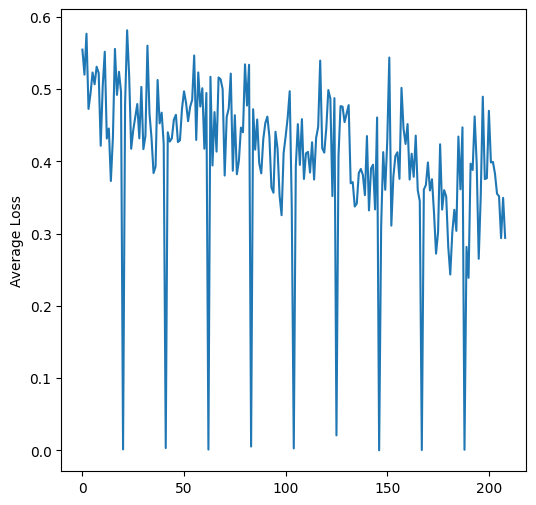

In [79]:
## 训练
## 训练次数过多会梯度爆炸

mode='load'#load:加载已经训过的模型;build:重新训练
epochs =10
lr=0.001
embedding_size=200
n_hidden=128
n_class=2
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lstm=LSTM(n_chars,embedding_size,n_hidden,n_class).to(device)
criterion=nn.NLLLoss()## result,target,


if mode=='load':
    lstm.load_state_dict(torch.load('lstm_parameter.pkl'))

train_k_epochs(lstm,epochs,lr,criterion,device)
torch.save(lstm.state_dict(),'lstm_parameter.pkl')

In [81]:
## 在完整测试集上计算测试结果
bad_list=[]
good_list=[]
c=0
for i,(text,label) in enumerate(tqdm(test_data)):
    text=text.to(device)
    output=evaluate(lstm,text)
    predict=torch.argmax(output)
    #print(output)
    if predict==label.item():
        c+=1
    if predict==0:
        bad_list.append(tensor_to_text(text))
    else :
        good_list.append(tensor_to_text(text))
print('acc:',c/len(test_data))

## 查看分类为好和分类为坏的样例
for x in random.sample(bad_list,5):
    print('bad: '+x)
for x in random.sample(good_list,5):
    print('good: '+x)

100%|██████████| 3597/3597 [00:35<00:00, 100.27it/s]

acc: 0.8443147067000278
bad: 根本就没送到，距离才1000多米，一个多小时都没有送过来（打电话来），还自己确认收货。。。奸商，百度外卖都没有监管麽。。。
bad: 送错餐，然后一个半小时以后才吃上
bad: 量很大，但是味道真的一般。等了一个多小时才送到，达到了超时赔付的时间，感觉百度超时赔付就是个摆设
bad: 菜量一般，有点少
bad: 多收了钱。
good: 送餐员很热情，很好吃谢谢
good: 超级超级快,好高大上的包装,还会再来哦
good: 很好吃,超值
good: 非常好吃下次再买不错不错
good: 肉的好吃。


## 直接使用torch.nn的API实现RNN,GRU,LSTM
### 运行速度快了很多，pytorch内部有进行优化

In [169]:
from torch import nn
class RNN(nn.Module):
    def __init__(self,word_count,embedding_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size=hidden_size
        self.embedding=nn.Embedding(word_count,embedding_size)
        self.rnn=nn.LSTM(embedding_size,hidden_size,num_layers=2,bidirectional=False,batch_first=True)
        #简单用LSTM或GRU进行替换即可
        self.cls=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=0)
    def forward(self,x):
        word_vector=self.embedding(x)
        output=self.rnn(word_vector)[0][-1]#hidden默认全零
        #返回值第一个是所有时间步的hidden,第二个是最后一个时间步hidden
        output=self.cls(output)
        output=self.softmax(output)
        return output
    
rnn=RNN(n_chars,embedding_size,n_hidden,n_class)
rnn(input_tensor)

tensor([-0.6904, -0.6959], grad_fn=<LogSoftmaxBackward0>)

In [170]:
def run_rnn(rnn,input_tensor):
    output=rnn(input_tensor)
    return output
## 训练和评估
def train(rnn,criterion,input_tensor,label_tensor,device=device):
    rnn.zero_grad()
    output=run_rnn(rnn,input_tensor)
    #print(output,label_tensor)
    loss=criterion(output.unsqueeze(0),label_tensor)
    loss.backward()
    #grad_clipping(rnn, 1)
    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-lr)
    return output,loss.item()

def evaluate(rnn,input_tensor,device=device):
    with torch.no_grad():
        output=run_rnn(rnn,input_tensor)
        return output


In [171]:
from tqdm import tqdm
import matplotlib.pyplot as plt
def train_k_epochs(net,epochs,lr,criterion,device,plot_loss=True):
    loss_sum=0
    all_losses=[]
    plot_every=100

    for epoch in range(epochs):
        random.shuffle(train_data)
        for i,(input_tensor,label_tensor) in enumerate(tqdm(train_data)):
            if i>2000:
                break
            input_tensor=input_tensor.to(device)
            label_tensor=label_tensor.to(device)
            output,loss=train(net,criterion,input_tensor,label_tensor.unsqueeze(0))
            loss_sum+=loss
            if i %plot_every==0:
                all_losses.append(loss_sum/plot_every)
                loss_sum=0
        c=0
        random.shuffle(test_data)
        for i,(text,label) in enumerate(tqdm(test_data)):
            if i>500:
                break
            text=text.to(device)
            output=evaluate(net,text)
            predict=torch.argmax(output)
            if predict==label.item():
                c+=1
        print('acc:',c/500)
        print(evaluate(net,input_tensor.cuda()))#检查是否有梯度爆炸
    if plot_loss:
        ## 损失变化图像
        plt.figure(figsize=(6,6))
        plt.ylabel('Average Loss')
        plt.plot(all_losses[1:])
        plt.show()




 14%|█▍        | 501/3597 [00:00<00:02, 1490.04it/s]


acc: 0.846
tensor([-3.3192, -0.0369], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1480.53it/s]


acc: 0.902
tensor([-0.0380, -3.2896], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1463.28it/s]


acc: 0.88
tensor([-0.0639, -2.7823], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1480.71it/s]


acc: 0.856
tensor([-0.0627, -2.8013], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1495.64it/s]


acc: 0.872
tensor([-2.6227, -0.0754], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1450.93it/s]


acc: 0.906
tensor([-0.5272, -0.8922], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1480.11it/s]


acc: 0.906
tensor([-0.0414, -3.2058], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1492.38it/s]


acc: 0.862
tensor([-0.0495, -3.0305], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1488.62it/s]


acc: 0.862
tensor([-0.1483, -1.9820], device='cuda:0')


 14%|█▍        | 501/3597 [00:00<00:02, 1477.69it/s]


acc: 0.872
tensor([-3.0241, -0.0498], device='cuda:0')


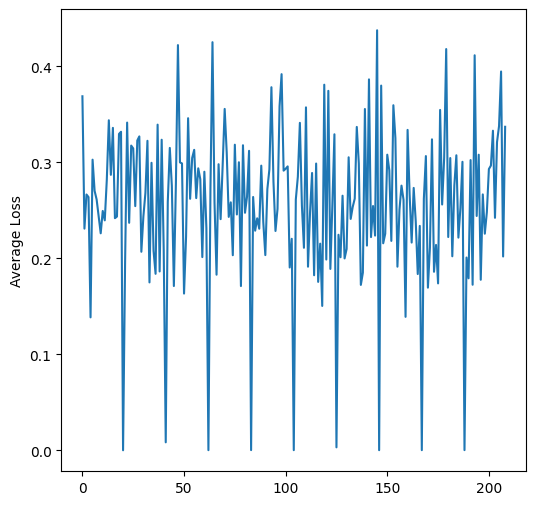

In [175]:
## 训练
## 多层RNN

mode='load'#load:加载已经训过的模型;build:重新训练
epochs =10
lr=0.001
embedding_size=200
n_hidden=128
n_class=2
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
rnn=RNN(n_chars,embedding_size,n_hidden,n_class).to(device)
criterion=nn.NLLLoss()## result,target,


if mode=='load':
    rnn.load_state_dict(torch.load('rnn_parameter.pkl'))

train_k_epochs(rnn,epochs,lr,criterion,device)
torch.save(rnn.state_dict(),'rnn_parameter.pkl')

In [176]:
## 在完整测试集上计算测试结果
bad_list=[]
good_list=[]
c=0
for i,(text,label) in enumerate(tqdm(test_data)):
    text=text.to(device)
    output=evaluate(rnn,text)
    predict=torch.argmax(output)
    #print(output)
    if predict==label.item():
        c+=1
    if predict==0:
        bad_list.append(tensor_to_text(text))
    else :
        good_list.append(tensor_to_text(text))
print('acc:',c/len(test_data))

## 查看分类为好和分类为坏的样例
for x in random.sample(bad_list,5):
    print('bad: '+x)
for x in random.sample(good_list,5):
    print('good: '+x)

100%|██████████| 3597/3597 [00:04<00:00, 836.01it/s]

acc: 0.8793438976925215
bad: 配送员说饭馆做错菜所以晚了，期间没人和我联系过
bad: 煎饼里沙拉酱太多了，齁咸齁咸的……
bad: 下雨天，配送慢，可以理解，商家为什么不接电话！
bad: 饭是冷的，郁闷
bad: 说是半小时到，结果1个多小时才来，也没有减免送餐费
good: 订的超大杯,送的大杯grande
good: 汉堡超小，跟烧饼似的，以前在店里吃的都觉得量很足所以才点的，没想到外卖差这么多。。。千万别买真的好小。。。
good: 很准时，菜品不错
good: 流沙包很好吃，蔬菜粥里在放些蔬菜就更好了
good: 送餐小哥速度很快，态度很好
